In [1]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
  %cd /content/drive/MyDrive/Notebooks/Repository/go-emotions/notebooks
except: pass

Mounted at /content/drive
/content/drive/MyDrive/Notebooks/Repository/go-emotions/notebooks


In [2]:
%run library_utils.ipynb

import os 
import numpy as np 
import matplotlib.pyplot as plt
import torch 
import transformers
assert transformers.__version__ >= '4.17.0'
from transformers import (
    AutoTokenizer, 
    AutoModel)
from tqdm import tqdm
from torch import Tensor
import torch.nn as nn

tqdm.pandas()
module = 'go-emotion-pool'
args = load_args(module)
filename = os.getcwd() + '/model.py'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
     |████████████████████████████████| 3.8 MB 14.6 MB/s 
     |████████████████████████████████| 6.5 MB 57.9 MB/s 
     |████████████████████████████████| 596 kB 68.0 MB/s 
     |████████████████████████████████| 895 kB 70.6 MB/s 
     |████████████████████████████████| 67 kB 6.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
device: cuda


In [3]:
args.model_name = 'go-emotion-pool-mini'
args.encoder_name = 'prajjwal1/bert-mini'
args.fc_hiddens = (100, 100)

### Tokenizer & Encoder

In [4]:
tokenizer = AutoTokenizer.from_pretrained(args.encoder_name)
encoder = AutoModel.from_pretrained(args.encoder_name)

Downloading:   0%|          | 0.00/286 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/43.0M [00:00<?, ?B/s]

Some weights of the model checkpoint at prajjwal1/bert-mini were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Loading dataset

In [5]:
%%time
dataset_path = os.path.join(args.output_dir, args.train_dataset_path)
assert os.path.exists(dataset_path)

train_dataset, val_dataset = generate_bert_dataset(
    dataset_path,     
    tokenizer, 
    emotions = args.emotions, 
    sentence_max_len = args.sentence_max_len, 
    split = args.validation_split_from_train
)

CPU times: user 12.9 s, sys: 667 ms, total: 13.6 s
Wall time: 17 s


## Building Model

In [6]:
# %%writefile -a $filename

class GoEmotionPoolClassifer(TransformerEncoderBase):
    def __init__(self, 
        encoder, 
        criterion = nn.BCEWithLogitsLoss(), 
        hiddens = None, 
        dropout_p: float = 0.1, 
        n_cls:int = 28
    ) -> None:
        config = {
            'hiddens':  [100] if hiddens is None else hiddens, 
            'dropout_p': dropout_p, 
            'n_cls': n_cls
        }
        super().__init__(encoder, criterion, config)

        # new layers 
        self.dropout = nn.Dropout(dropout_p)

        # full connected
        fcs = []
        in_feature = self.encoder_dim 
        for h in self.config['hiddens']:
            fcs.append(nn.Linear(in_feature, h))
            fcs.append(nn.ReLU())
            in_feature = h    

        # final layer 
        fcs.append(nn.Linear(in_feature, n_cls))
        self.fcs = nn.Sequential(*fcs)

    def forward(self, input_ids, attention_mask, y_true=None):
        encoder_output = super().forward(input_ids, attention_mask)
        pool_output = encoder_output['pooler_output']

        z = self.dropout(pool_output)
        logits = self.fcs(z)

        if y_true is not None:
            loss = self.criterion(logits, y_true)
            return (loss, logits)

        return logits


In [7]:
def create_go_emotion_pool(args, encoder):
    return GoEmotionPoolClassifer(
        encoder, 
        hiddens = args.fc_hiddens, 
        dropout_p = args.dropout_p, 
        n_cls = len(args.emotions)
    )

model = create_go_emotion_pool(args, encoder)
model

GoEmotionPoolClassifer(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 256, padding_idx=0)
      (position_embeddings): Embedding(512, 256)
      (token_type_embeddings): Embedding(2, 256)
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=256, out_features=256, bias=True)
              (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise

## Utility to predict on examples

In [8]:
def proba_on_examples(texts, model):
    X_tk = tokenize_bert_inputs(
        texts, tokenizer, maxlen = args.sentence_max_len
    )
    X_tk['input_ids'] = Tensor(X_tk['input_ids']).type(torch.int32)
    X_tk['attention_mask'] = Tensor(X_tk['attention_mask']).type(torch.int32)
    proba = predict_proba_examples(X_tk, model)
    return proba

In [9]:
proba = proba_on_examples(['hello my name is jeongwon', 'nice to meet you!'], model.cpu())
proba_to_emotion(
    proba,
    args.classification_threshold, 
    args.emotions, 
)[0][:3]

[('admiration', 0.48338053), ('amusement', 0.46668455), ('anger', 0.5285328)]

In [10]:
proba = predict_proba_examples(val_dataset[:5], model)
y_true = val_dataset[:5]['y_true'].numpy()
compute_classification_metrics(y_true, proba, 0.1)

{'accuracy': 0.044444444444444446,
 'macro_f1': 0.0670194003527337,
 'macro_precision': 0.044444444444444446,
 'macro_recall': 0.14814814814814814,
 'micro_f1': 0.0851063829787234,
 'micro_precision': 0.044444444444444446,
 'micro_recall': 1.0,
 'weighted_f1': 0.49206349206349215,
 'weighted_precision': 0.3333333333333333,
 'weighted_recall': 1.0}

In [11]:
# testing evaluate
# evaluate(
#     model, 
#     val_dataset, 
#     batch_size = args.eval_batch_size, 
#     threshold = args.classification_threshold, 
#     device = args.device
# )

# testing saving
# model = create_go_emotion_pool(args, encoder)
# _ = save_checkpoint(
#     model, 
#     args.output_dir, 
#     model_name='testmodel',
#     metadata=args
# )

# model_copy, _ = load_from_checkpoint(
#     args.output_dir,
#     model_name='testmodel',
#     checkpoint_id='null-model', 
#     model_cls=GoEmotionPoolClassifer
# )

# check_model_same(model, model_copy)

In [12]:
# clear_archive(args.output_dir, args.model_name)

In [ ]:
model = create_go_emotion_pool(args, encoder)
model, metadata = train(
    model, 
    train_dataset, 
    val_dataset, 
    dict(args), 
    tokenizer, 
    epochs=args.train_epochs, 
    train_batch_size = args.train_batch_size, 
    val_batch_size = args.eval_batch_size, 
    save_steps = args.save_steps, 
    validation_steps= args.validation_steps, 
    archive_dir = args.output_dir, 
    model_name = args.model_name, 
    classification_threshold = args.classification_threshold, 
    learning_rate = args.learning_rate, 
    grad_clip_max = args.grad_clip_max, 
    weight_decay = args.weight_decay, 
    warmup_ratio = args.warmup_ratio, 
    logging_metrics= ['macro_f1', 'macro_precision', 'macro_recall'],
    continue_training=False,
    device = args.device
)

In [16]:
args.model_name

'go-emotion-pool-tiny'

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

df = get_attrs_from_checkpoints_meta(args.output_dir, args.model_name, [
    'tr_metrics.loss', 
    'tr_metrics.trigger_rate',
    'val_metrics.loss', 
    'val_metrics.trigger_rate', 
    'val_metrics.accuracy', 
    'val_metrics.macro_f1',
    'val_metrics.micro_f1'
])
df.head(3)

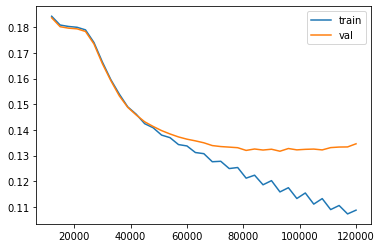

In [ ]:
plt.plot(df['checkpoint_id'][3:], df['tr_metrics.loss'][3:], label='train')
plt.plot(df['checkpoint_id'][3:], df['val_metrics.loss'][3:], label='val')
plt.legend()

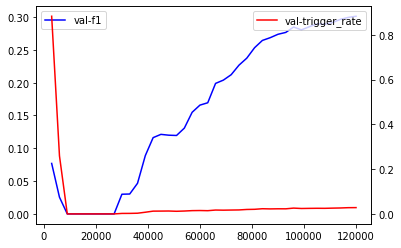

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(df['checkpoint_id'], 
         df['val_metrics.macro_f1'], 
         label='val-f1', c='blue')
ax2.plot(df['checkpoint_id'], 
         df['val_metrics.trigger_rate'], 
         label='val-trigger_rate', c='red')

ax1.legend()
ax2.legend()

## Checking final model 


{'accuracy': 0.9551815881775313, 'macro_precision': 0.4247178911006871, 'macro_recall': 0.2677487611458235, 'macro_f1': 0.301257060538418, 'micro_precision': 0.5379927735533625, 'micro_recall': 0.32244093215682473, 'micro_f1': 0.4032173315549089, 'weighted_precision': 0.48637275746316827, 'weighted_recall': 0.32244093215682473, 'weighted_f1': 0.3586162861972523}


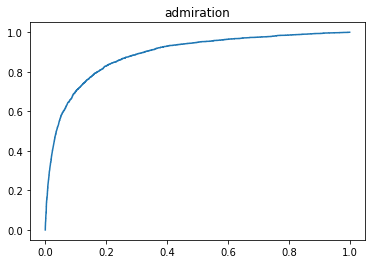

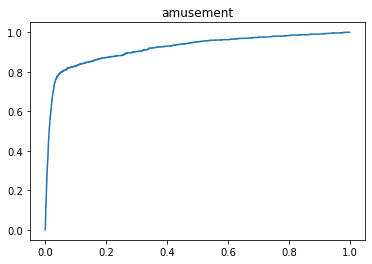

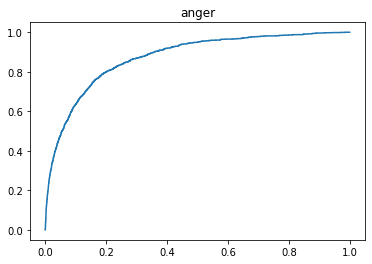

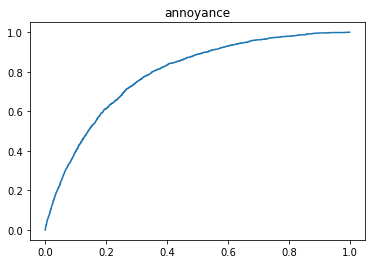

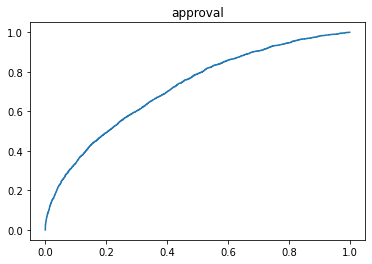

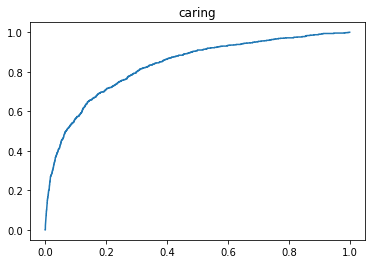

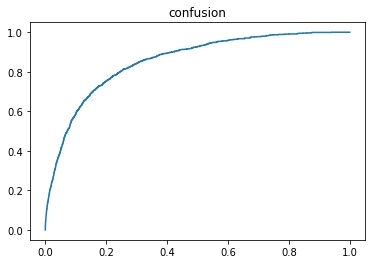

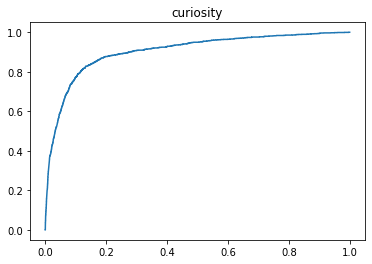

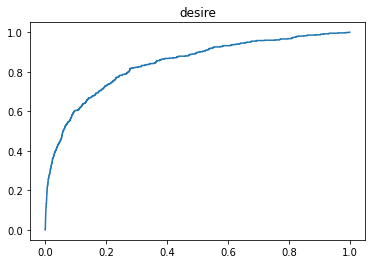

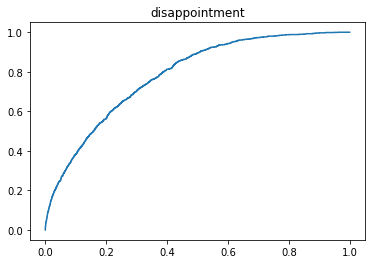

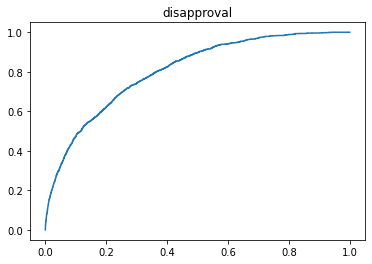

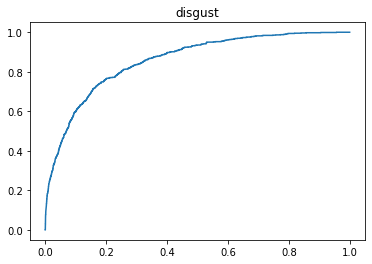

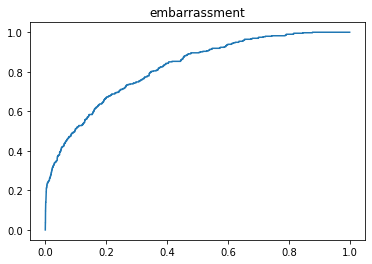

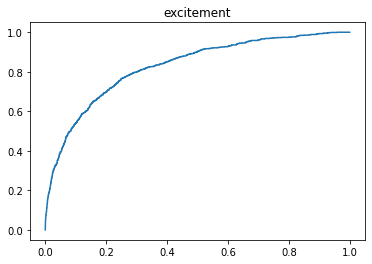

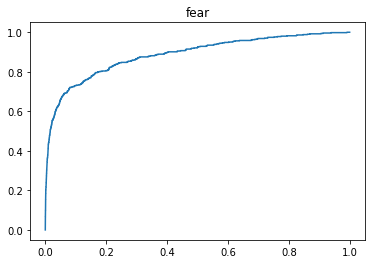

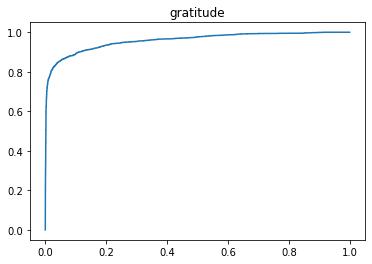

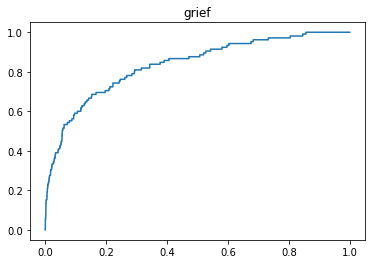

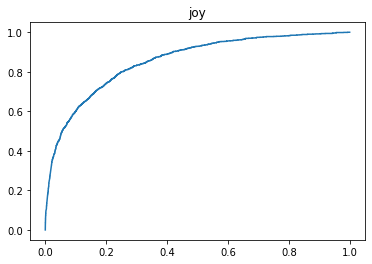

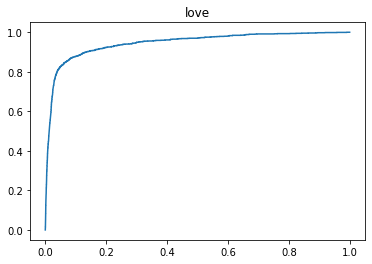

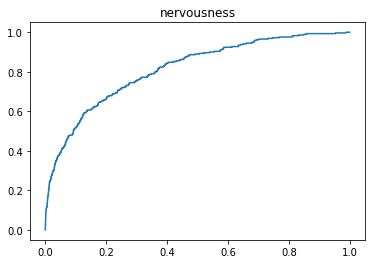

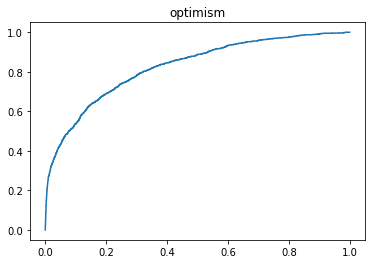

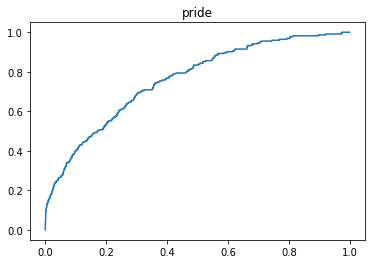

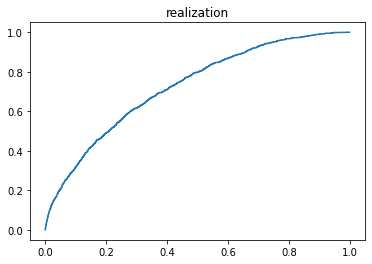

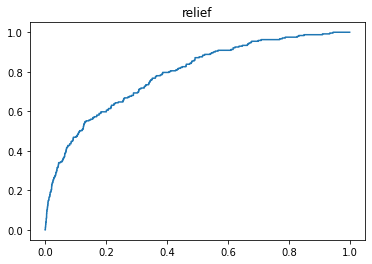

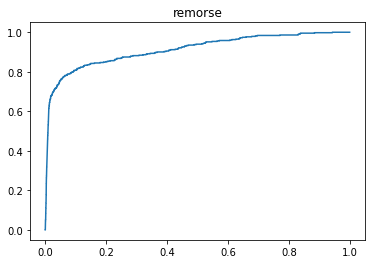

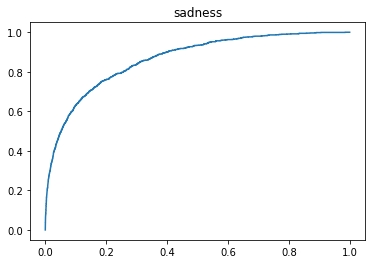

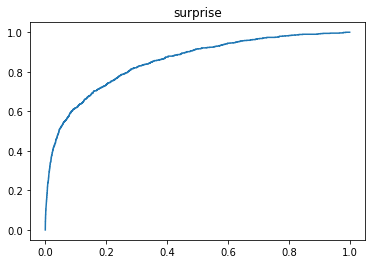

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

model, meta = load_from_checkpoint(
    args.output_dir, 
    args.model_name, 
    checkpoint_id='120000', 
    load_metadata=True,
    load_model=True, 
    model_cls=GoEmotionPoolClassifer
)

proba = predict_proba(
    model, 
    val_dataset, 
    batch_size = args.eval_batch_size, 
    device = args.device
)
y_true = val_dataset[:]['y_true'].numpy()

val_final = compute_classification_metrics(y_true, proba, threshold=args.classification_threshold)
print(val_final)

for i, emt in enumerate(args.emotions):
    fpr, tpr, _ = roc_curve(y_true[:, i], proba[:, i])
    plt.plot(fpr, tpr)
    plt.title(emt)
    plt.show()


In [ ]:
proba_to_emotion(
    proba_on_examples([
        'hi nice to meet you', 
        'yes!! I got accepted', 
        'god dam it why would you do that?', 
        'i am terribly sorry',
        'i love you',
        'what is wrong with the weather today?'
    ], model), 
    0.4, 
    args.emotions)

[[('gratitude', 0.647659)],
 [('approval', 0.824923)],
 [('curiosity', 0.46190378)],
 [('remorse', 0.6433513), ('sadness', 0.44906622)],
 [('love', 0.92590946)],
 [('curiosity', 0.62056893)]]